In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'
from setup import *

⚠️ **IMPORTANT** : run `./utils/artr_hmm_sampler.jl` to get the file `./Models/hmms_ARTR_outputs.h5`

In [3]:
assert nOUTPATH.exists(), "⚠️ IMPORTANT : run `./utils/artr_hmm_sampler.jl` to get the file `./Models/hmms_ARTR_outputs.h5`"

# Figure

## h_FLR hists

In [3]:
from scipy.stats import gaussian_kde
from scipy.signal import savgol_filter

In [5]:
Lhs, Rhs = [], []
for artr in ALL_ARTRs:
    h = load_ARTR_fields(nMODELPATH, *artr)
    _,_,L,_,_ = load_ARTR(nDATAPATH, *artr)
    
    nL = L.shape[1]
    
    Lh = h[:,:nL]
    Rh = h[:,nL:]

    Lhs.append(Lh.T)
    Rhs.append(Rh.T)
Lhs = np.concatenate(Lhs).T
Rhs = np.concatenate(Rhs).T
Lhs.shape, Rhs.shape

((3, 4561), (3, 5263))

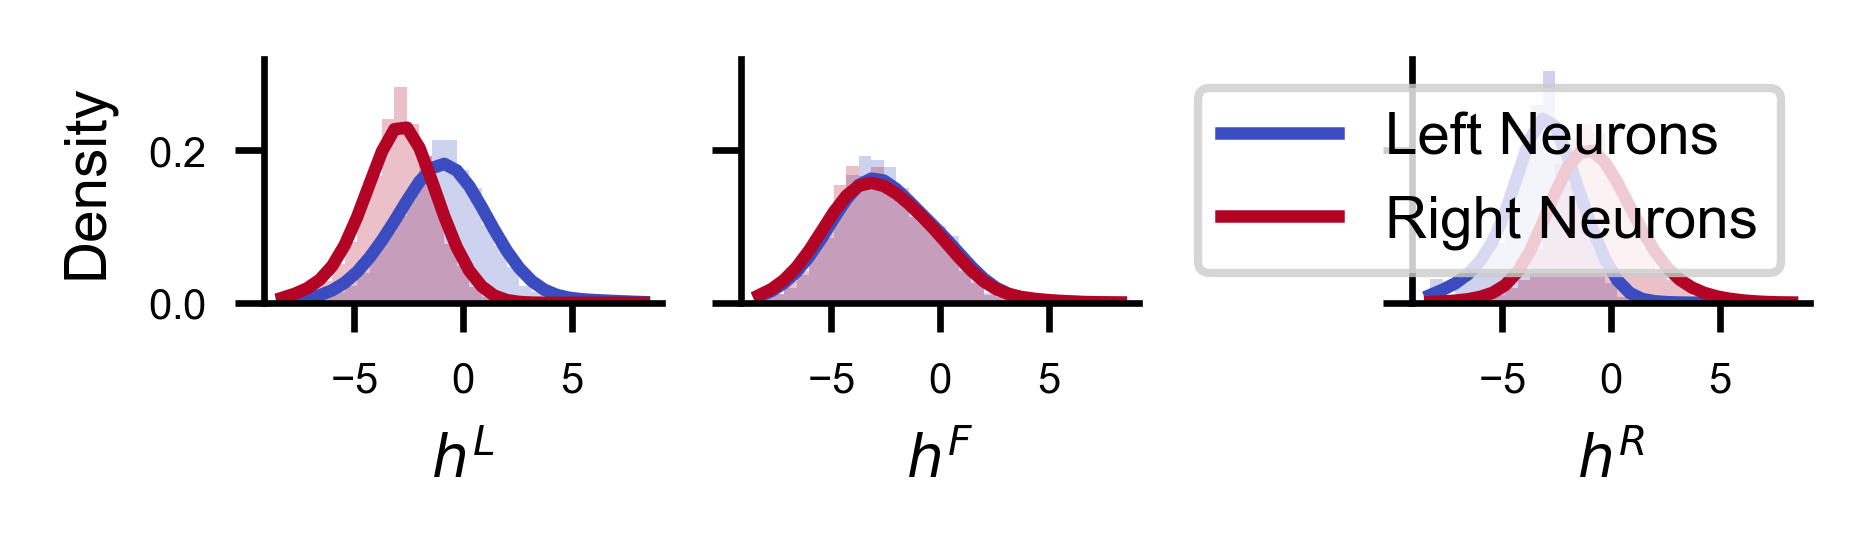

In [7]:
fig, axs = plt.subplots(ncols=3, figsize=(3*1, 0.8), sharey=True)
axs[0].set_ylabel("Density")
for s, ax, state in zip([1,0,2], axs, ["L", "F", "R"]):
    l = max(np.abs(Lhs).max(), np.abs(Rhs).max())
    bins = np.linspace(-l, +l, 30)
    ax.hist(Lhs[s], density=True, bins=bins, color=COLOR_Lartr, alpha=0.25);
    ax.hist(Rhs[s], density=True, bins=bins, color=COLOR_Rartr, alpha=0.25);
    ax.plot(bins, gaussian_kde(Lhs[s], 0.5)(bins), color=COLOR_Lartr, label="Left Neurons")
    ax.plot(bins, gaussian_kde(Rhs[s], 0.5)(bins), color=COLOR_Rartr, label="Right Neurons")
    ax.set_xlabel(f"$h^{state}$")
ax.legend()

fig.savefig("panels/Fig4/emissions.svg")

## Example activity

In [39]:
artr = ALL_ARTRs[3]
mL, mR, _, _, dt = load_ARTR(nDATAPATH, *artr)

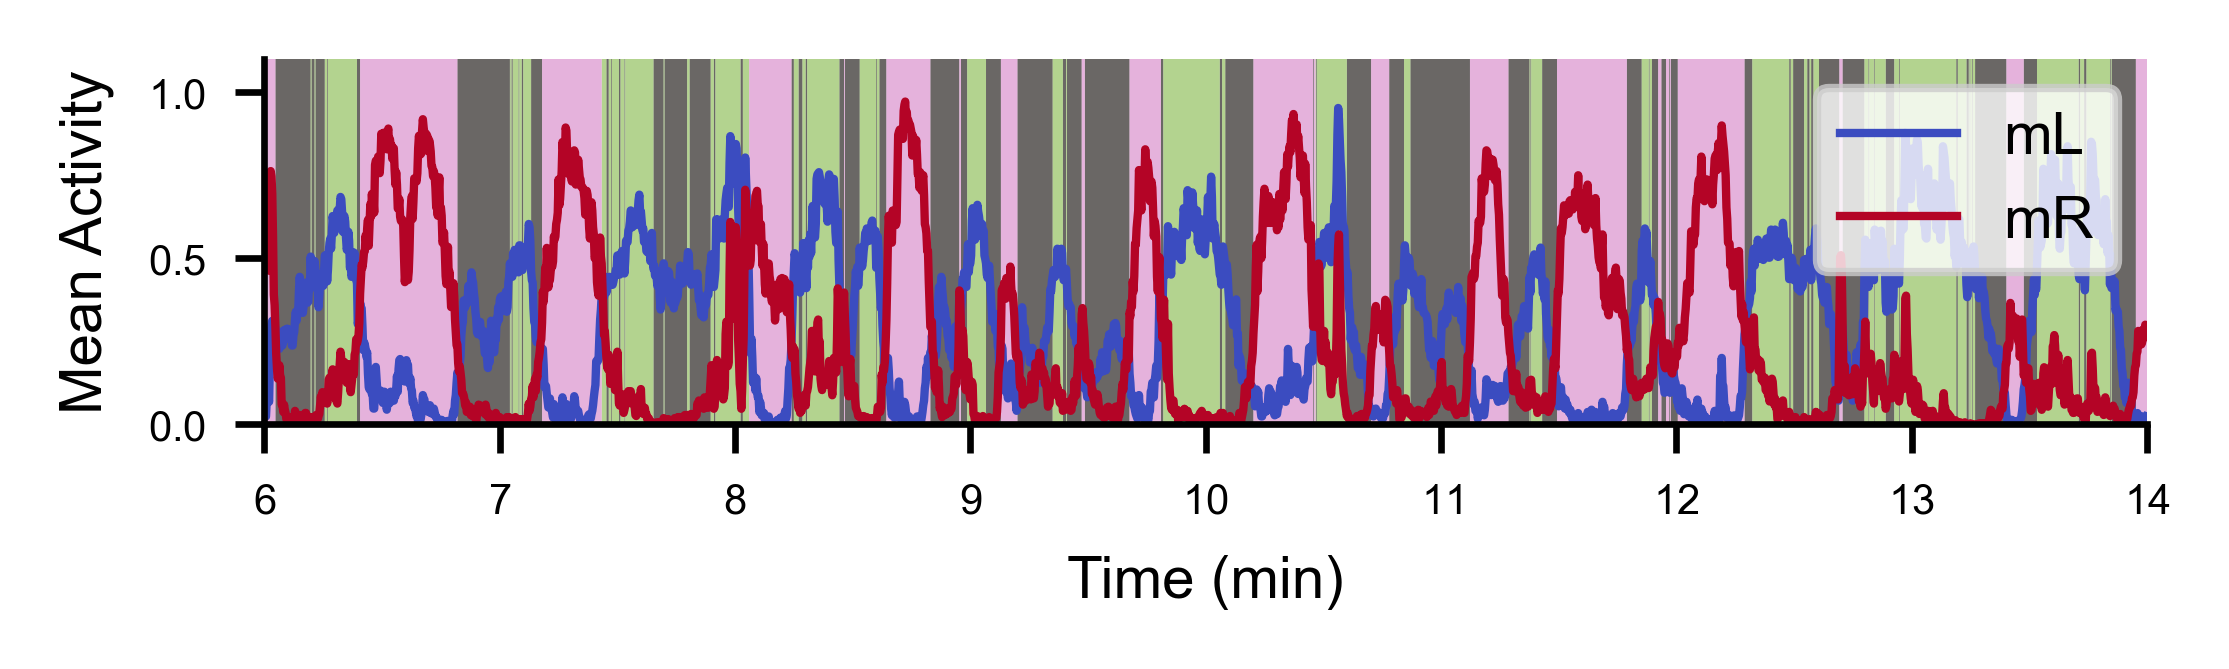

In [41]:
fig, ax = plt.subplots(nrows=1, figsize=(2*1.8,1), sharex=True)
t = np.arange(0,len(mL)*dt, dt)

a = 0.65
mmin, mmax = 0, 1.1
ax.fill_between(t/60,np.where(seq==0, mmax,mmin), facecolor=FLR_colors[0], step="post", alpha=a)
ax.fill_between(t/60,np.where(seq==1, mmax,mmin), facecolor=FLR_colors[1], step="post", alpha=a)
ax.fill_between(t/60,np.where(seq==2, mmax,mmin), facecolor=FLR_colors[2], step="post", alpha=a)

ax.plot(t/60, mL, color=COLOR_Lartr, linewidth=1, label="mL")
ax.plot(t/60, mR, color=COLOR_Rartr, linewidth=1, label="mR")

ax.set_xlabel("Time (min)")
ax.set_ylabel("Mean Activity")
ax.legend()

ax.set_xlim(6,14)
ax.set_ylim(mmin, mmax)

fig.savefig("panels/Fig4/exmaple_classification.svg")

## Magnetization

In [20]:
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm

def find_level(X, q, ls=np.linspace(0,100,10000)):
    ps = []
    for l in ls:
        inside = X > l
        ins = X[inside].sum()
        outs = X[~inside].sum()
        ps.append(ins/(ins+outs))
    ps = np.array(ps)
    return ls[np.argmin(np.abs(ps-q))]

In [10]:
mLs, mRs, Seqs = [], [], []
for artr in ALL_ARTRs:
    mL, mR = load_ARTR_magnet(nDATAPATH, *artr).T
    seq = load_ARTR_viterbi(nOUTPATH, *artr)
    mLs.append(mL)
    mRs.append(mR)
    Seqs.append(seq)
mLs = np.concatenate(mLs)
mRs = np.concatenate(mRs)
Seqs = np.concatenate(Seqs)

bins = np.linspace(0,1,100)
hF, xF, yF = np.histogram2d(mLs[Seqs==0], mRs[Seqs==0], bins=bins, density=True)
hL, xL, yL = np.histogram2d(mLs[Seqs==1], mRs[Seqs==1], bins=bins, density=True)
hR, xR, yR = np.histogram2d(mLs[Seqs==2], mRs[Seqs==2], bins=bins, density=True)

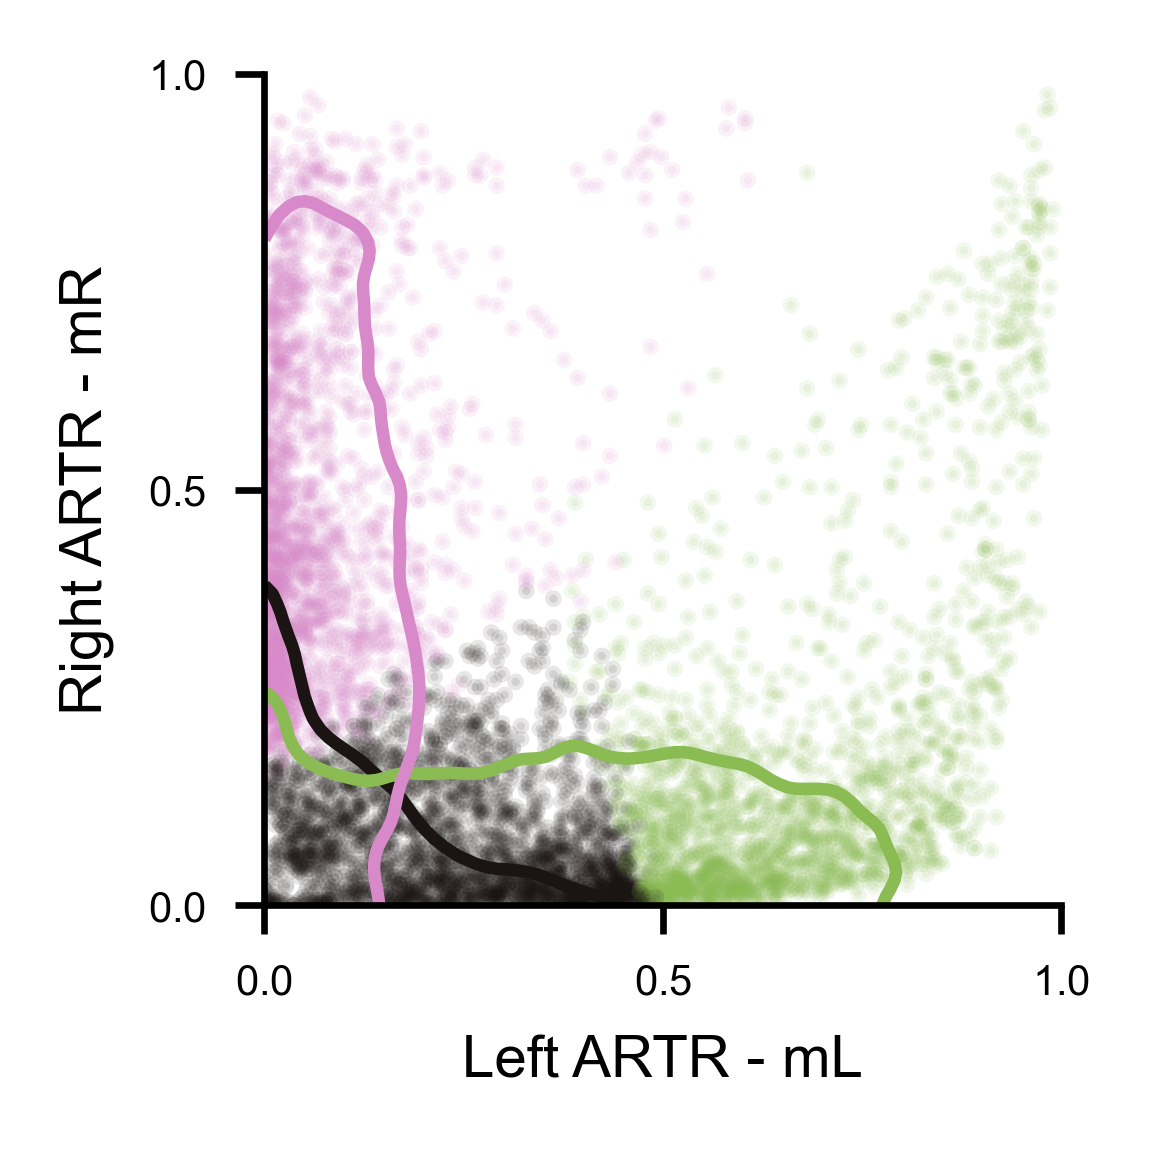

In [34]:
fig, ax = plt.subplots(figsize=(1.8,1.8))

artr = ALL_ARTRs[3]
mL, mR = load_ARTR_magnet(nDATAPATH, *artr).T
#order = artr_field_order2(*artr)
seq = load_ARTR_viterbi(nOUTPATH, *artr)
ax.scatter(mL, mR, c=FLR_colors[seq], s=1, alpha=0.1, rasterized=True)
beta = 0.9
CS = ax.contour(xF[:-1], yF[:-1], gaussian_filter(hF.T, 2), [find_level(hF, beta)], colors=[FLR_colors[0]])
CS = ax.contour(xL[:-1], yL[:-1], gaussian_filter(hL.T, 2), [find_level(hL, beta)], colors=[FLR_colors[1]])
CS = ax.contour(xR[:-1], yR[:-1], gaussian_filter(hR.T, 2), [find_level(hR, beta)], colors=[FLR_colors[2]])
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xlabel("Left ARTR - mL")
ax.set_ylabel("Right ARTR - mR")
ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])

fig.savefig("panels/Fig4/magnetisation_classification.svg")

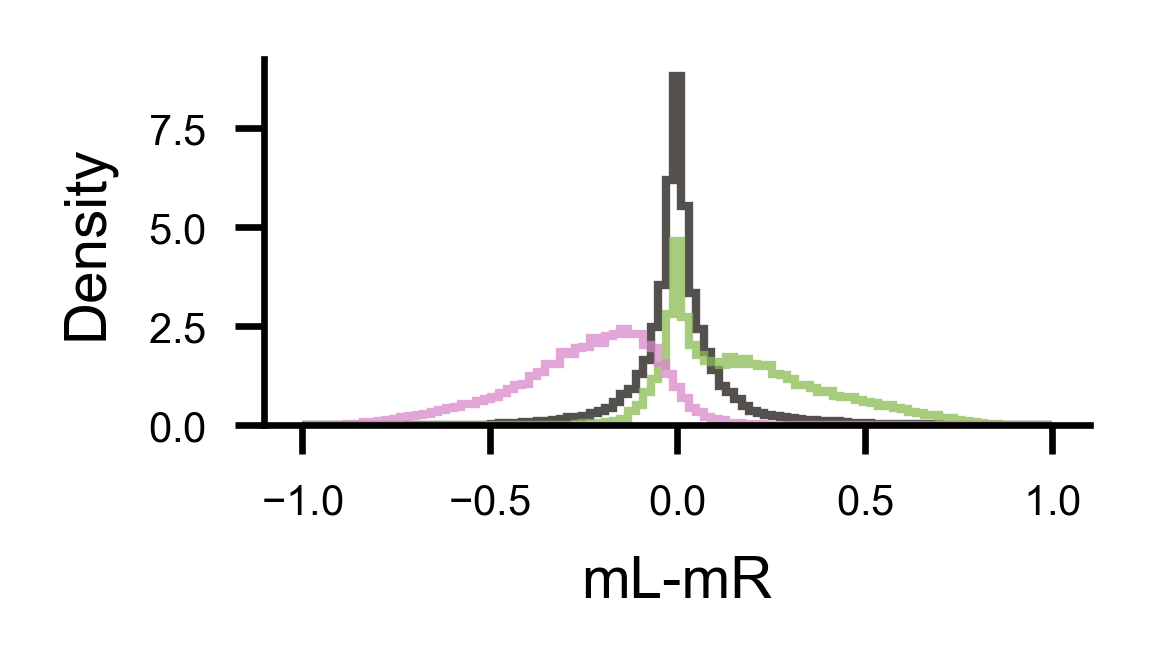

In [35]:
fig, ax = plt.subplots(figsize=(1.8,1))
bins = np.linspace(-1,+1,100)
mLRs = mLs - mRs
ax.hist(mLRs[Seqs==0], color=FLR_colors[0], bins=bins, alpha=0.75, histtype="step", density=True);
ax.hist(mLRs[Seqs==1], color=FLR_colors[1], bins=bins, alpha=0.75, histtype="step", density=True);
ax.hist(mLRs[Seqs==2], color=FLR_colors[2], bins=bins, alpha=0.75, histtype="step", density=True);
ax.set_xlabel("mL-mR")
ax.set_ylabel("Density")

fig.savefig("panels/Fig4/mLR_classification.svg")

## statistics reproduction

In [108]:
from matplotlib.colors import LogNorm

def get_rasters(fish, temp, stack=False):
    _, genL, genR = load_ARTR_gen(nOUTPATH, *artr)
    _,_,L,R,_ = load_ARTR(nDATAPATH, *artr)
    if stack:
        return np.hstack([L,R]), np.hstack([genL,genR])
    else:
        return L,R,genL,genR

### mean

In [115]:
datas, gens = [], []
for artr in ALL_ARTRs:
    data, gen = get_rasters(*artr, stack=True)
    datas.append(data.mean(axis=0))
    gens.append(gen.mean(axis=0))
datas = np.concatenate(datas)
gens = np.concatenate(gens)

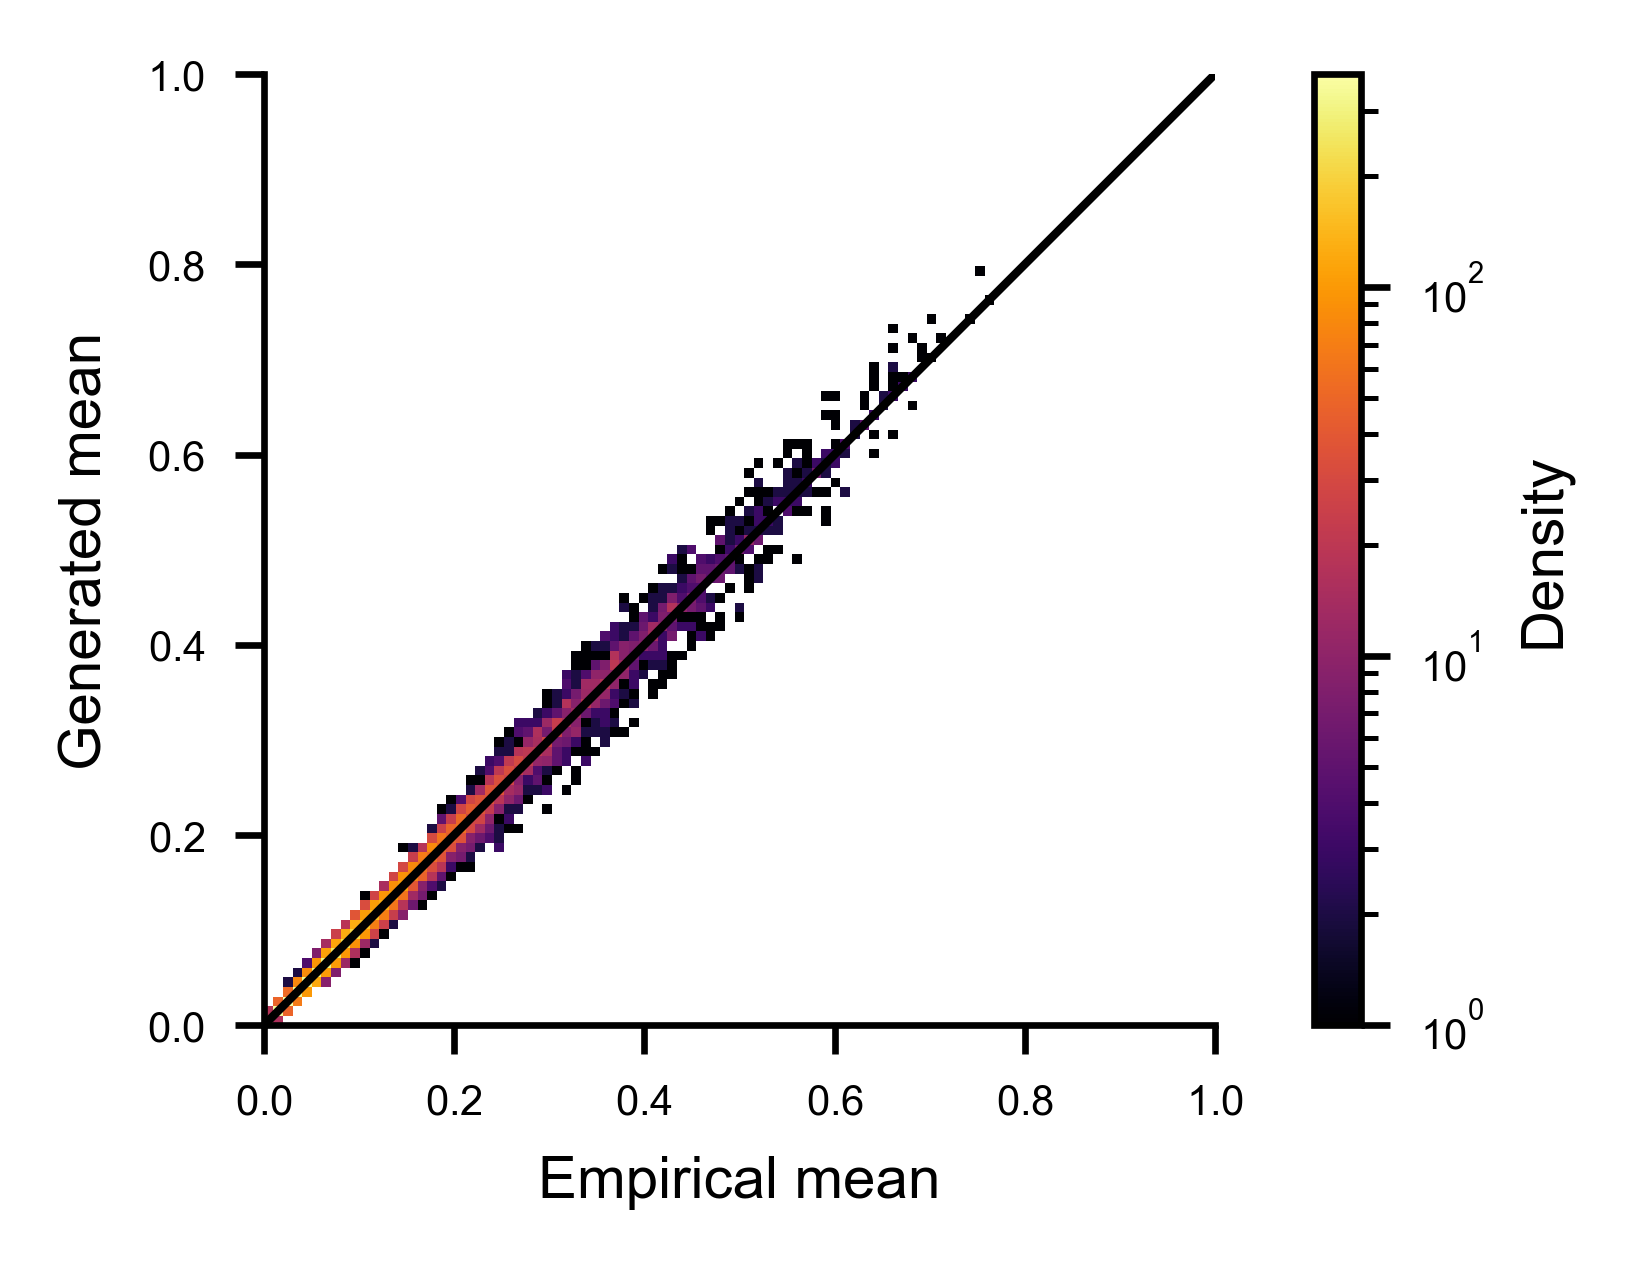

In [139]:
fig, ax = plt.subplots(figsize=(3,2))
mmin, mmax = min(datas.min(), gens.min()), max(datas.max(), gens.max())
h,x,y,hp = ax.hist2d(datas, gens, bins=np.linspace(0,1,100), norm=LogNorm(), cmap="inferno", density=True);
ax.plot([0, 1], [0, 1], linewidth=1)
fig.colorbar(hp, ax=ax, label="Density")
ax.set_aspect(1)
ax.set_xlabel("Empirical mean")
ax.set_ylabel("Generated mean")
fig.savefig("panels/Fig4/mean.svg")

### cov

In [176]:
def latteralized_cov(L,R):
    nL = L.shape[1]
    C = np.cov(L.T,R.T)
    sC = np.concatenate([C[:nL,:nL].ravel(), C[nL:,nL:].ravel()])
    oC = np.concatenate([C[nL:,:nL].ravel(), C[nL:,:nL].ravel()])
    return sC, oC

In [184]:
sCs, oCs, sCgens, oCgens = [], [], [], []
for artr in ALL_ARTRs:
    L,R,genL,genR = get_rasters(*artr)
    sC, oC = latteralized_cov(L,R)
    sCgen, oCgen = latteralized_cov(genL, genR)
    sCs.append(sC)
    oCs.append(oC)
    sCgens.append(sCgen)
    oCgens.append(oCgen)
sCs = np.concatenate(sCs)
oCs = np.concatenate(oCs)
sCgens = np.concatenate(sCgens)
oCgens = np.concatenate(oCgens)

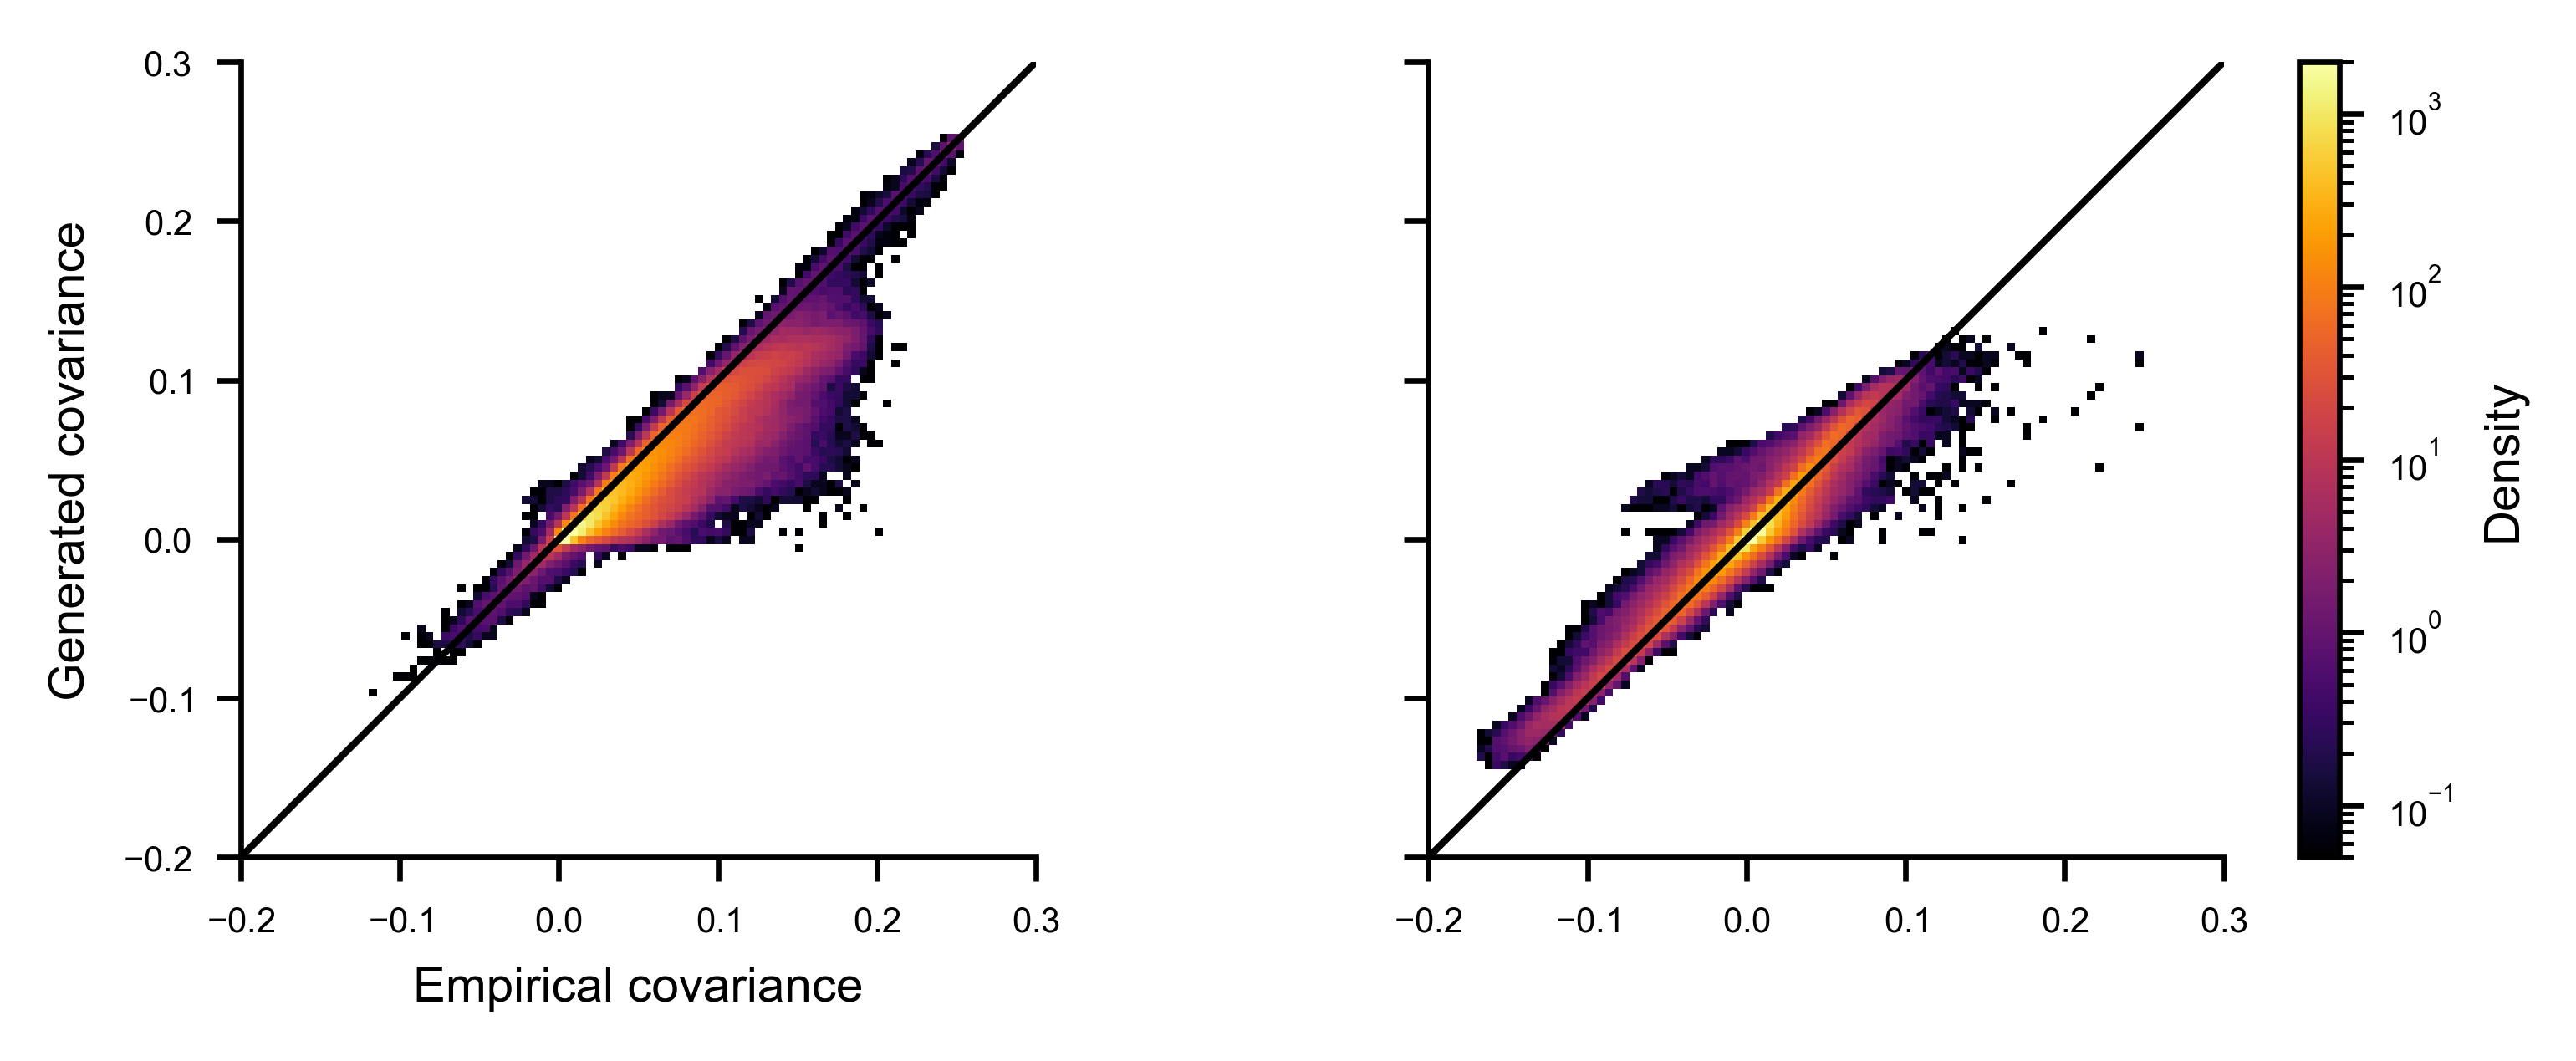

In [203]:
fig, axs = plt.subplots(ncols=2, figsize=(2*2+1,2), sharex=True, sharey=True)

_,_,_,h1 = axs[0].hist2d(
    sCs, sCgens, 
    bins=np.linspace(-0.2,+0.3,100), norm=LogNorm(vmin=5.0e-2, vmax=2.0e+3), 
    cmap="inferno", 
    density=True
)
_,_,_,h2 = axs[1].hist2d(
    oCs, oCgens,
    bins=np.linspace(-0.2,+0.3,100), norm=LogNorm(vmin=5.0e-2, vmax=2.0e+3), 
    cmap="inferno", 
    density=True
)

#fig.colorbar(h1, ax=axs[0], label="Density")
fig.colorbar(h2, ax=axs[1], label="Density")

for ax in axs:
    ax.plot([-0.2, +0.3], [-0.2, +0.3], linewidth=1)
    ax.set_aspect(1)
axs[0].set_xlabel("Empirical covariance")
axs[0].set_ylabel("Generated covariance")

fig.savefig("panels/Fig4/cov.svg")

# Supplementaries